In [1]:
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# (Non)Linear IA Models

In [7]:
from linear_alingment_models import ii_plus_projected
from hrh_model import HRH

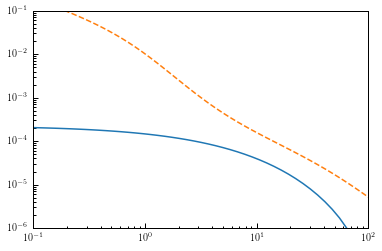

In [10]:
rp = np.logspace(-1,2.2,50)
xi = ii_plus_projected(rp, 0.0)

hrh = HRH()
hrh.ii_plus_projected(rp)

plt.plot(rp, xi, '-')
plt.plot(rp, hrh.ii_plus_projected(rp), '--')
plt.yscale('log')
plt.xscale('log')
plt.ylim([10**(-6),10**(-1)])
plt.xlim([0.1,100])
plt.show()